In [367]:
import pandas as pd
import numpy as np
import pickle

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import scipy.stats as st

from imblearn.over_sampling import ADASYN, SMOTE

from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.metrics import make_scorer
from sklearn.feature_selection import SelectKBest
from sklearn.neighbors import KNeighborsClassifier
from lightgbm import LGBMClassifier

from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder
from hyperopt import hp, tpe, space_eval
from hyperopt.fmin import fmin

from matplotlib.ticker import FormatStrFormatter
import os

In [117]:
def specificity(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return round(tn / (tn + fp), 2)

def sensitivity(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return round(tp / (tp + fn), 2)

def harmonic(y_true, y_pred, **kwargs):
    sens = sensitivity(y_true, y_pred)
    spec = specificity(y_true, y_pred)
    return round((2 * sens * spec) / (sens + spec), 2)

my_harmonic = make_scorer(harmonic, greater_is_better=True)

In [104]:
le = LabelEncoder()
X_train = pd.get_dummies(pd.read_csv('train.csv').drop(columns=['Площадка', 'p_total_ppg', 'lf_ppg', 'hf_ppg', 'vlf_ppg']), columns=['Пол'])
y_train = le.fit_transform(X_train.pop('Наличие НУО'))

X_test = pd.get_dummies(pd.read_csv('test.csv').drop(columns=['Площадка', 'p_total_ppg', 'lf_ppg', 'hf_ppg', 'vlf_ppg']), columns=['Пол'])
y_test = le.transform(X_test.pop('Наличие НУО'))

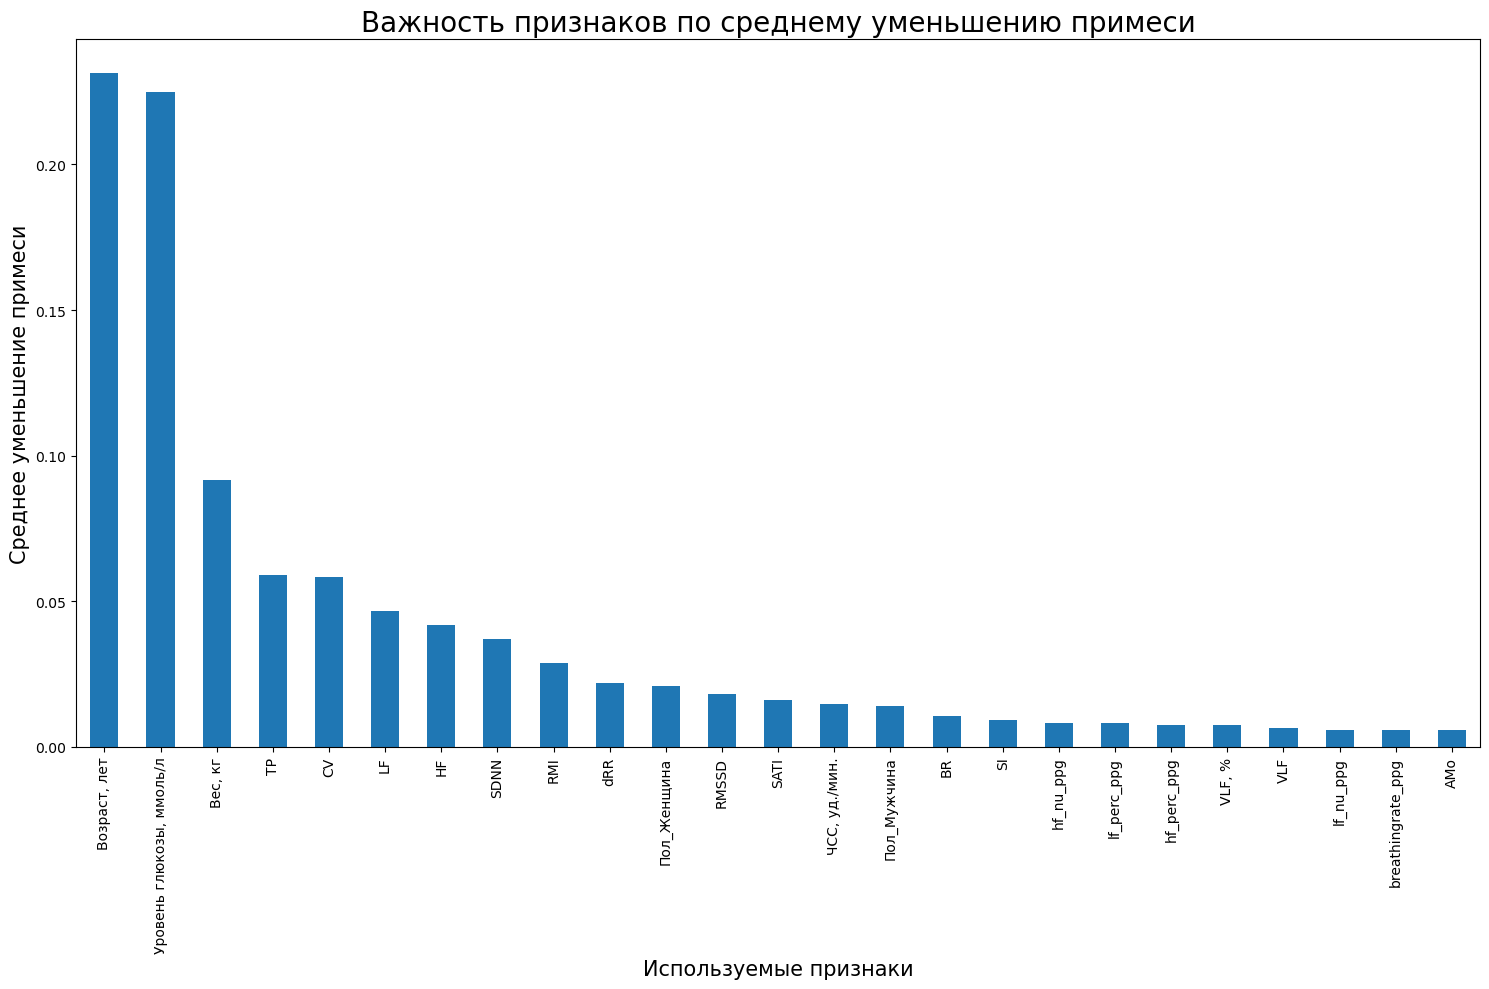

In [417]:
model = RandomForestClassifier()
selector = SelectKBest(k=25)
X_train_selected = selector.fit_transform(X_train, y_train)
model.fit(X_train_selected, y_train)
fig, ax = plt.subplots(figsize=(15, 10))
importances = model.feature_importances_
forest_importances = pd.Series(importances, index=list(X_train.columns[selector.get_support()])).sort_values(ascending=False)
forest_importances.plot.bar(ax=ax)
ax.set_title("Важность признаков по среднему уменьшению примеси", fontsize=20)
ax.set_ylabel("Среднее уменьшение примеси", fontsize=15)
ax.set_xlabel("Используемые признаки", fontsize=15)
fig.tight_layout()

In [317]:
def get_initial_qulity(model, X_train, y_train, X_test, y_test, header=False):
    selector = SelectKBest(k=25)
    X_train = selector.fit_transform(X_train, y_train)
    model.fit(X_train, y_train)
    X_test = selector.transform(X_test)
    preds = model.predict(X_test)
    pd.DataFrame.from_dict({'sensitivity': [sensitivity(y_test, preds)], 
                            'specificity': [specificity(y_test, preds)], 
                            'harmonic':[harmonic(y_test, preds)],
                            'roc_auc': [round(roc_auc_score(y_test, model.predict_proba(X_test)[:, 1]), 2)]}).to_csv(f'results/initial_quality.csv', mode='a', index=False, header=header)

In [318]:
for i, model in enumerate([XGBClassifier(), LGBMClassifier(), RandomForestClassifier(random_state=42), AdaBoostClassifier()]):
    if i:
        get_initial_qulity(model, X_train, y_train, X_test, y_test)
    else:
        get_initial_qulity(model, X_train, y_train, X_test, y_test, header=True)

In [319]:
pd.read_csv('results/initial_quality.csv')

,sensitivity,specificity,harmonic,roc_auc
0,0.31,0.91,0.46,0.67
1,0.31,0.82,0.45,0.65
2,0.40,0.86,0.55,0.66
3,0.43,0.77,0.55,0.63


In [393]:
def get_sampling_mx_cls(model, X_train, y_train, X_test, y_test):
    samples_dict = {}
    class_count = Counter(y_train).values()
    init_ratio = round(min(class_count) / max(class_count), 1)
    minority_ratio = np.arange(init_ratio + 0.1, 1.1, 0.1)
    selector = SelectKBest(k=25)
    X_train_selected = selector.fit_transform(X_train, y_train)
    model.fit(X_train_selected, y_train)
    X_test = selector.transform(X_test)
    initial_preds = model.predict(X_test)
    sens_res, spec_res, harmonic_res, roc_res = [[] for i in range(4)]
    sens_res.append([sensitivity(y_test, initial_preds)]*len(minority_ratio))
    spec_res.append([specificity(y_test, initial_preds)]*len(minority_ratio))
    harmonic_res.append([harmonic(y_test, initial_preds)]*len(minority_ratio))
    roc_res.append([round(roc_auc_score(y_test, model.predict_proba(X_test)[:, 1]), 2)]*len(minority_ratio))
    for sampling_strategy in [ADASYN, SMOTE]:
        sens_res_temp, spec_res_temp, harmonic_res_temp, roc_res_temp = [[] for i in range(4)]
        for ratio in minority_ratio:
            sampler = sampling_strategy(sampling_strategy=ratio, random_state=5)
            X_resampled, y_resampled = sampler.fit_resample(X_train_selected, y_train)
            samples_dict[f'{re.findall(r"[A-Z]+", str(ADASYN))[0]}_{str(ratio)}'] = X_resampled
            model.fit(X_resampled, y_resampled)
            predictions = model.predict(X_test)
            sens_res_temp.append(sensitivity(y_test, predictions))
            spec_res_temp.append(specificity(y_test, predictions))
            harmonic_res_temp.append(harmonic(y_test, predictions))
            roc_res_temp.append(round(roc_auc_score(y_test, model.predict_proba(X_test)[:, 1]), 2))
        sens_res.append(sens_res_temp)
        spec_res.append(spec_res_temp)
        harmonic_res.append(harmonic_res_temp)
        roc_res.append(roc_res_temp)
    return np.array(sens_res), np.array(spec_res), np.array(harmonic_res), np.array(roc_res), samples_dict, list(X_train.columns[selector.get_support()])

In [302]:
get_sampling_mx_cls(XGBClassifier(), X_train, y_train, X_test, y_test)

(array([[0.31, 0.31, 0.31, 0.31, 0.31, 0.31, 0.31],
        [0.38, 0.38, 0.38, 0.36, 0.42, 0.39, 0.42],
        [0.34, 0.38, 0.4 , 0.4 , 0.38, 0.38, 0.4 ]]),
 array([[0.91, 0.91, 0.91, 0.91, 0.91, 0.91, 0.91],
        [0.82, 0.91, 0.86, 0.86, 0.82, 0.82, 0.82],
        [0.91, 0.86, 0.86, 0.91, 0.91, 0.86, 0.86]]),
 array([[0.46, 0.46, 0.46, 0.46, 0.46, 0.46, 0.46],
        [0.52, 0.54, 0.53, 0.51, 0.56, 0.53, 0.56],
        [0.5 , 0.53, 0.55, 0.56, 0.54, 0.53, 0.55]]),
 array([[0.67, 0.67, 0.67, 0.67, 0.67, 0.67, 0.67],
        [0.69, 0.7 , 0.71, 0.68, 0.7 , 0.7 , 0.7 ],
        [0.69, 0.68, 0.7 , 0.69, 0.7 , 0.68, 0.71]]))

In [304]:
get_sampling_mx_cls(LGBMClassifier(), X_train, y_train, X_test, y_test)

(array([[0.31, 0.31, 0.31, 0.31, 0.31, 0.31, 0.31],
        [0.38, 0.39, 0.38, 0.4 , 0.44, 0.44, 0.44],
        [0.34, 0.37, 0.41, 0.37, 0.4 , 0.41, 0.42]]),
 array([[0.82, 0.82, 0.82, 0.82, 0.82, 0.82, 0.82],
        [0.82, 0.82, 0.82, 0.82, 0.82, 0.82, 0.82],
        [0.82, 0.82, 0.82, 0.82, 0.82, 0.82, 0.82]]),
 array([[0.45, 0.45, 0.45, 0.45, 0.45, 0.45, 0.45],
        [0.52, 0.53, 0.52, 0.54, 0.57, 0.57, 0.57],
        [0.48, 0.51, 0.55, 0.51, 0.54, 0.55, 0.56]]),
 array([[0.65, 0.65, 0.65, 0.65, 0.65, 0.65, 0.65],
        [0.69, 0.7 , 0.7 , 0.7 , 0.68, 0.67, 0.68],
        [0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.7 ]]))

In [320]:
get_sampling_mx_cls(RandomForestClassifier(random_state=42), X_train, y_train, X_test, y_test)

(array([[0.4 , 0.4 , 0.4 , 0.4 , 0.4 , 0.4 , 0.4 ],
        [0.38, 0.39, 0.38, 0.41, 0.4 , 0.38, 0.4 ],
        [0.38, 0.38, 0.41, 0.4 , 0.37, 0.38, 0.43]]),
 array([[0.86, 0.86, 0.86, 0.86, 0.86, 0.86, 0.86],
        [0.86, 0.82, 0.82, 0.82, 0.82, 0.82, 0.82],
        [0.86, 0.86, 0.86, 0.86, 0.86, 0.82, 0.86]]),
 array([[0.55, 0.55, 0.55, 0.55, 0.55, 0.55, 0.55],
        [0.53, 0.53, 0.52, 0.55, 0.54, 0.52, 0.54],
        [0.53, 0.53, 0.56, 0.55, 0.52, 0.52, 0.57]]),
 array([[0.66, 0.66, 0.66, 0.66, 0.66, 0.66, 0.66],
        [0.68, 0.69, 0.74, 0.73, 0.71, 0.73, 0.72],
        [0.66, 0.68, 0.72, 0.69, 0.7 , 0.69, 0.72]]))

In [306]:
get_sampling_mx_cls(AdaBoostClassifier(), X_train, y_train, X_test, y_test)

(array([[0.43, 0.43, 0.43, 0.43, 0.43, 0.43, 0.43],
        [0.42, 0.47, 0.47, 0.42, 0.48, 0.46, 0.49],
        [0.48, 0.51, 0.46, 0.43, 0.49, 0.39, 0.53]]),
 array([[0.77, 0.77, 0.77, 0.77, 0.77, 0.77, 0.77],
        [0.82, 0.82, 0.64, 0.86, 0.82, 0.82, 0.82],
        [0.68, 0.86, 0.77, 0.82, 0.82, 0.82, 0.68]]),
 array([[0.55, 0.55, 0.55, 0.55, 0.55, 0.55, 0.55],
        [0.56, 0.6 , 0.54, 0.56, 0.61, 0.59, 0.61],
        [0.56, 0.64, 0.58, 0.56, 0.61, 0.53, 0.6 ]]),
 array([[0.63, 0.63, 0.63, 0.63, 0.63, 0.63, 0.63],
        [0.64, 0.65, 0.64, 0.65, 0.7 , 0.67, 0.68],
        [0.64, 0.69, 0.64, 0.66, 0.68, 0.66, 0.67]]))

In [394]:
sens_cube, spec_cube, harm_cube, roc_auc_cube = [np.array([]).reshape(-1, 7) for i in range(4)]
class_count = Counter(y_train).values()
init_ratio = round(min(class_count) / max(class_count), 1)
minority_ratio = np.arange(init_ratio + 0.1, 1.1, 0.1)
for model in [XGBClassifier(), LGBMClassifier(), RandomForestClassifier(random_state=42), AdaBoostClassifier()]:
    sens, spec, harm, roc_auc, samples_dict, feature_names = get_sampling_mx_cls(model, X_train, y_train, X_test, y_test)
    sens_cube = np.vstack([sens_cube, sens])
    spec_cube = np.vstack([spec_cube, spec])
    harm_cube = np.vstack([harm_cube, harm])
    roc_auc_cube = np.vstack([roc_auc_cube, roc_auc])
sens_cube = sens_cube.reshape(-1, 3, len(minority_ratio))
spec_cube = spec_cube.reshape(-1, 3, len(minority_ratio))
harm_cube = harm_cube.reshape(-1, 3, len(minority_ratio))
roc_auc_cube = roc_auc_cube.reshape(-1, 3, len(minority_ratio))

In [326]:
roc_auc_cube

array([[[0.67, 0.67, 0.67, 0.67, 0.67, 0.67, 0.67],
        [0.69, 0.7 , 0.71, 0.68, 0.7 , 0.7 , 0.7 ],
        [0.69, 0.68, 0.7 , 0.69, 0.7 , 0.68, 0.71]],

       [[0.65, 0.65, 0.65, 0.65, 0.65, 0.65, 0.65],
        [0.69, 0.7 , 0.7 , 0.7 , 0.68, 0.67, 0.68],
        [0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.7 ]],

       [[0.66, 0.66, 0.66, 0.66, 0.66, 0.66, 0.66],
        [0.68, 0.69, 0.74, 0.73, 0.71, 0.73, 0.72],
        [0.66, 0.68, 0.72, 0.69, 0.7 , 0.69, 0.72]],

       [[0.63, 0.63, 0.63, 0.63, 0.63, 0.63, 0.63],
        [0.64, 0.65, 0.64, 0.65, 0.7 , 0.67, 0.68],
        [0.64, 0.69, 0.64, 0.66, 0.68, 0.66, 0.67]]])

In [375]:
def plot_res_for_metric(metric_cube, metric_name, trim_nm=False, models=['XGB', 'LGBM', 'Случайный лес', 'AdaBoost'], samplers=['без сэмплинга', 'ADASYN', 'SMOTE']):
    class_count = Counter(y_train).values()
    init_ratio = round(min(class_count) / max(class_count), 1)
    minority_ratio = np.arange(init_ratio + 0.1, 1.1, 0.1)
    fig, axs = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle(metric_name, fontsize=20)
    fig.tight_layout(pad=5.0)
    for i, res_mx in enumerate(metric_cube):
        axs[i // 2, i % 2].yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
#         axs[i // 2, i % 2].set_yticks(np.arange(np.round(np.min(res_mx), 2), np.round(np.max(res_mx), 2) + 0.2, 0.02))
        axs[i // 2, i % 2].grid(which='both')
        for j, strategy in enumerate(samplers):
            if strategy == 'без сэмплинга':
                continue
            axs[i // 2, i % 2].plot(minority_ratio, res_mx[j, :], 'o', color='r')
            axs[i // 2, i % 2].plot(minority_ratio, res_mx[j, :], label= strategy)
        axs[i // 2, i % 2].plot(minority_ratio, res_mx[0, :], '--', color='purple', label='без сэмплинга', linewidth=2)
        if trim_nm:
            axs[i // 2, i % 2].set_ylabel('F мера', fontsize=15)
        else:
            axs[i // 2, i % 2].set_ylabel(metric_name, fontsize=15)
        axs[i // 2, i % 2].set_xlabel('Отношение объемов классов', fontsize=15)
        axs[i // 2, i % 2].set_xticks(minority_ratio)
        axs[i // 2, i % 2].set_title(models[i], fontsize=15)
        axs[i // 2, i % 2].legend()


## Sensitivity

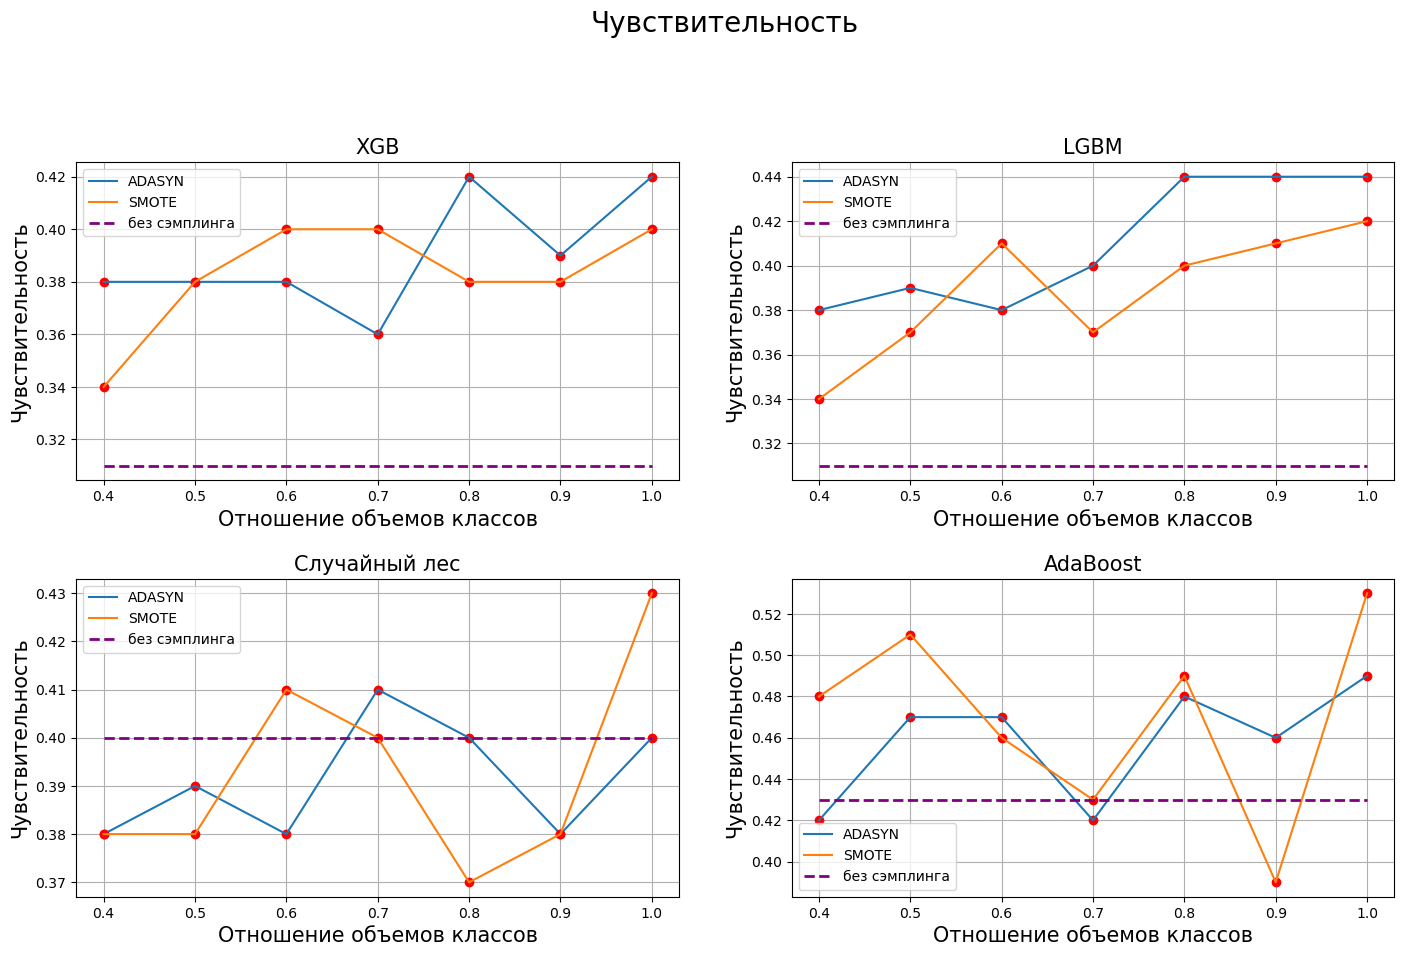

In [398]:
plot_res_for_metric(sens_cube, 'Чувствительность')

## Specificity

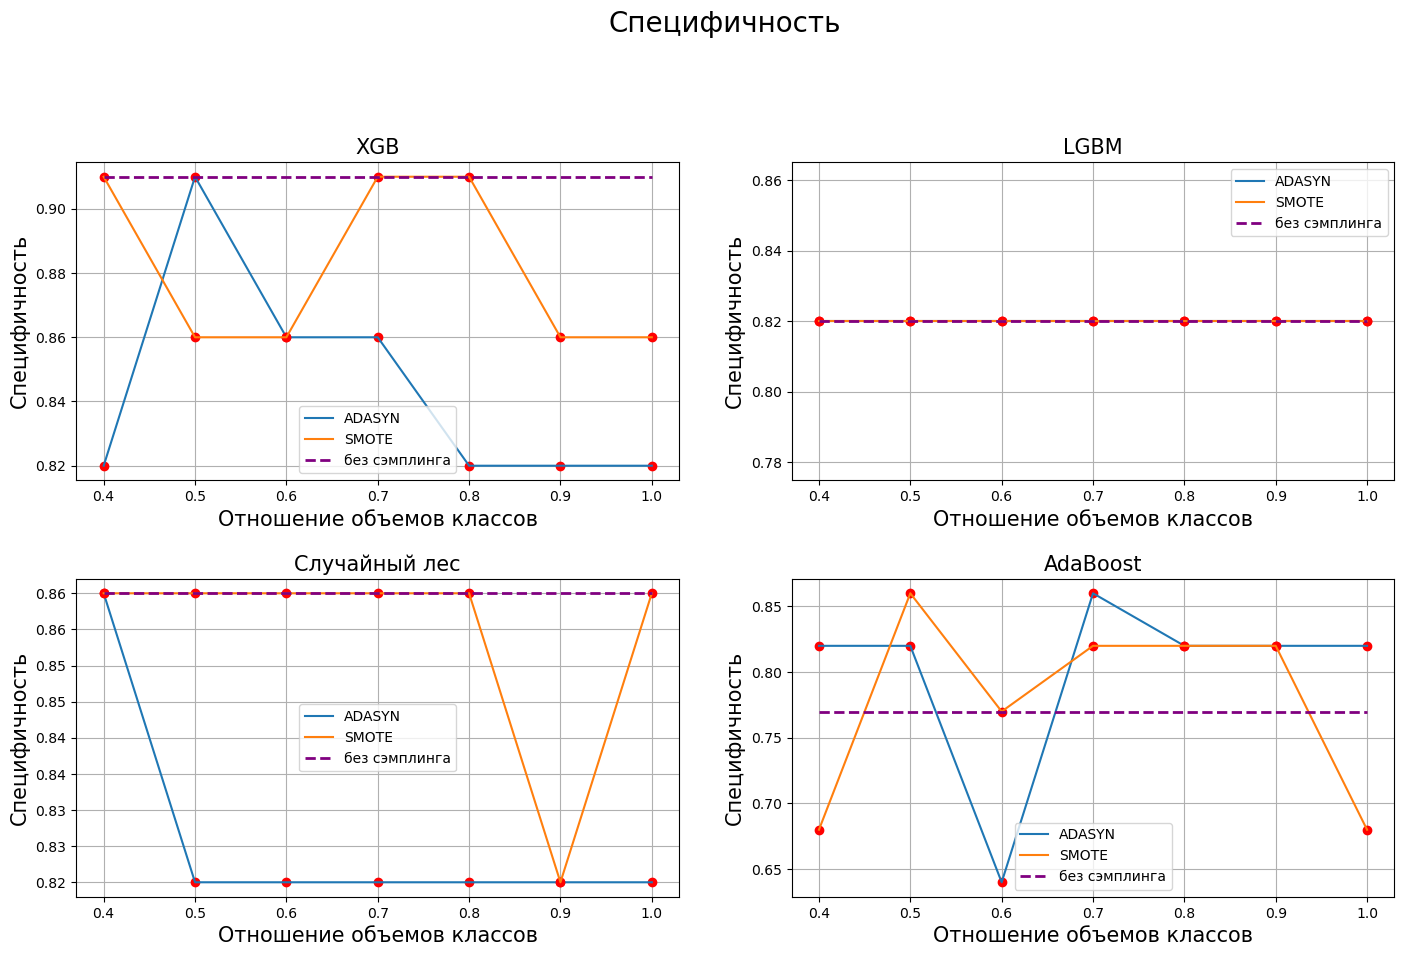

In [399]:
plot_res_for_metric(spec_cube, 'Специфичность')

## Harmonic

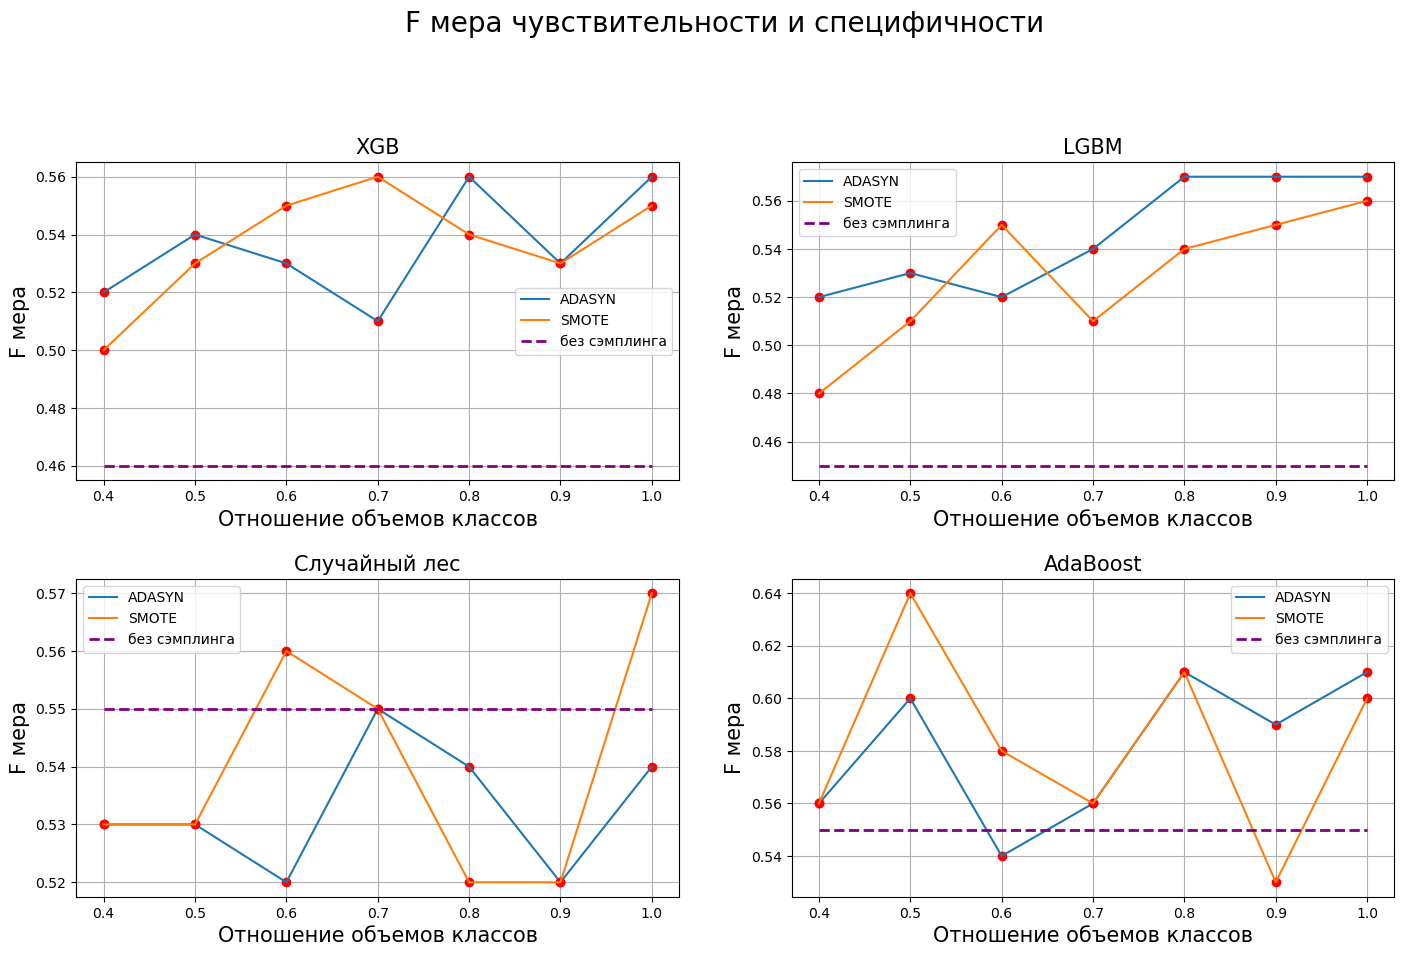

In [400]:
plot_res_for_metric(harm_cube, 'F мера чувствительности и специфичности', trim_nm=True)

## ROC_AUC

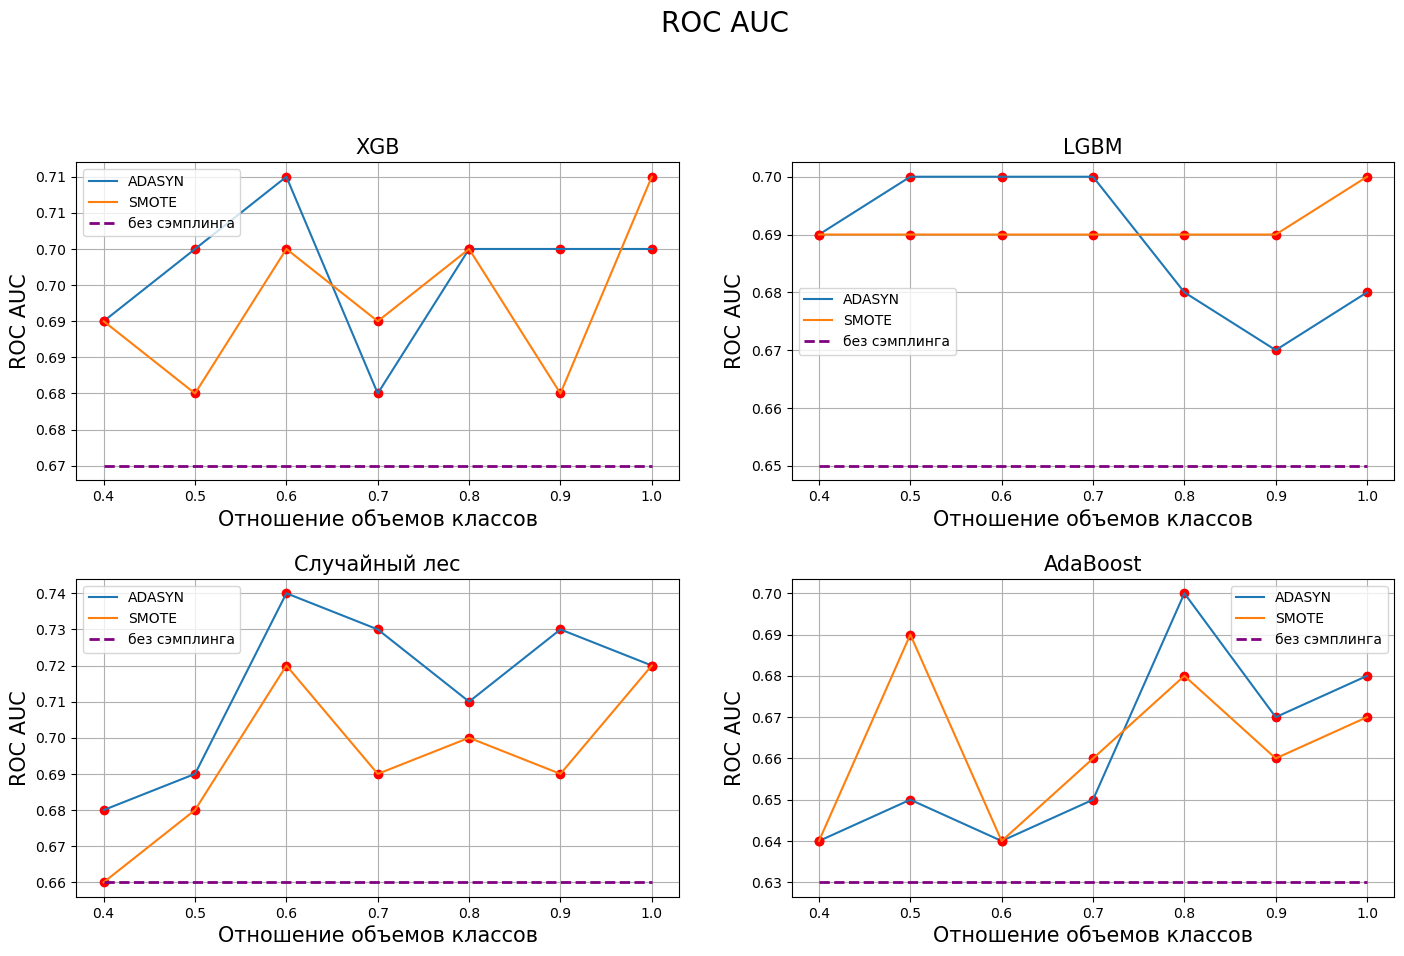

In [401]:
plot_res_for_metric(roc_auc_cube, 'ROC AUC')

## Sample charachteristics display

In [459]:
def plot_charachterisitcs(sample, ratio):
    sample_df = pd.DataFrame(sample, columns=feature_names)
    fig, axs = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle('Сравнение сэмплированной и исходной выборок', fontsize=20)
    fig.tight_layout(pad=5.0)
    cnt_sampled = Counter(le.inverse_transform(list(y_train) + [1] * int(ratio*1945 - 626)))
    cnt = Counter(le.inverse_transform(list(y_train)))
    features = ['Уровень глюкозы, ммоль/л', 'Возраст, лет', 'Вес, кг', 'Наличие НУО']
    for i, feature in enumerate(features):
        if feature == 'Наличие НУО':
            axs[i // 2, i % 2].bar(cnt_sampled.keys(), cnt_sampled.values(), width=0.5, label='Сэмплированная выборка')
            axs[i // 2, i % 2].bar(cnt.keys(), cnt.values(), width=0.5, label='Исходная выборка')
        else:
            axs[i // 2, i % 2].hist(sample_df[feature], rwidth=0.7, label='Сэмплированная выборка')
            axs[i // 2, i % 2].hist(X_train[feature], rwidth=0.7, label='Исходная выборка')
        axs[i // 2, i % 2].legend(loc='upper right')
        axs[i // 2, i % 2].grid(which='both')
        axs[i // 2, i % 2].set_title(feature, fontsize=15)

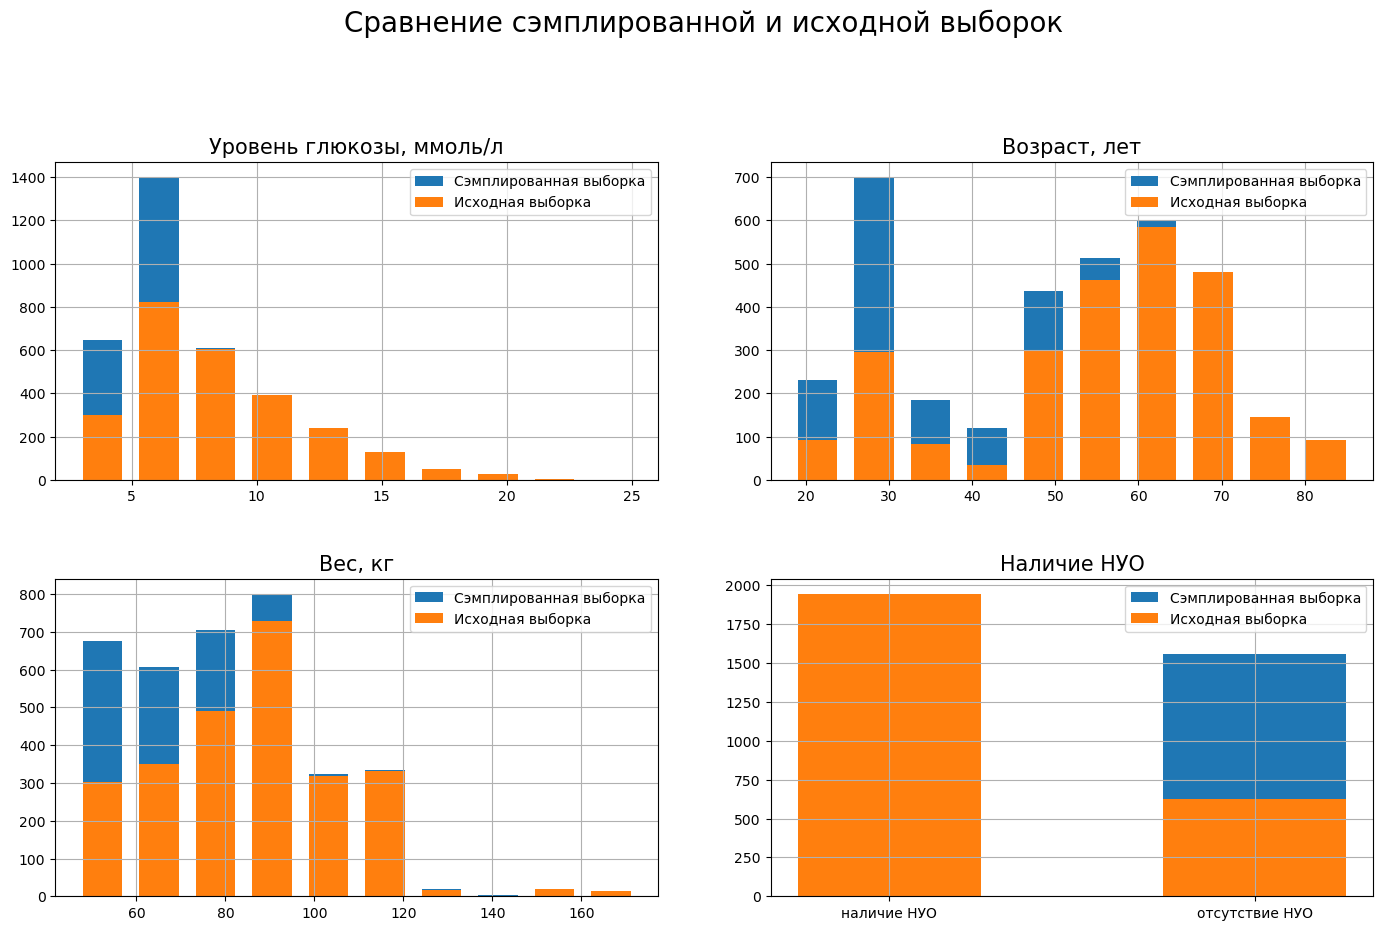

In [463]:
plot_charachterisitcs(samples_dict['ADASYN_0.7999999999999999'], 0.8)